In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


U-Net모델 설계

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64, batch_norm=True, dropout=True)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128, batch_norm=True, dropout=True)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256, batch_norm=True, dropout=True)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512, batch_norm=True, dropout=True)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024, batch_norm=True, dropout=True)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512, batch_norm=True, dropout=True)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512, batch_norm=True, dropout=True)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256, batch_norm=True, dropout=True)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256, batch_norm=True, dropout=True)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128, batch_norm=True, dropout=True)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128, batch_norm=True, dropout=True)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64, batch_norm=True, dropout=True)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64, batch_norm=True, dropout=True)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64, batch_norm=True, dropout=True)

        self.fc = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True), nn.Sigmoid())



    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)


        return x

class CBR2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True,
                 batch_norm=False, activation='relu', dropout=False):
        super().__init__()

        layers = []
        layers += [nn.Conv2d(in_channels=in_channels,
                             out_channels=out_channels,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding,
                             bias=bias)]

        if batch_norm:
            layers += [nn.BatchNorm2d(num_features=out_channels)]

        if activation.lower() == 'relu':
            layers += [nn.ReLU()]
        elif activation.lower() == 'leakyrelu':
            layers += [nn.LeakyReLU()]
        else:
            raise NotImplementedError

        if dropout:
            layers += [nn.Dropout(p=0.5)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)




데이터 전처리

In [4]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split

class DroneDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform

        self.image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".jpg")])
        self.mask_paths = sorted([os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir) if mask.endswith(".png")])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")

        # OpenCV를 이용해 마스크 이미지를 흑백으로 변환
        mask = cv2.imread(self.mask_paths[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        mask_red = np.isin(mask[:,:,0], [253, 254, 255])
        mask_green = mask[:,:,1] == 0
        mask_blue = mask[:,:,2] == 0
        mask = np.all(np.stack([mask_red, mask_green, mask_blue], axis=2), axis=2)
        mask = np.where(mask, 255, 0).astype(np.uint8)
        mask = Image.fromarray(mask)

        if self.transform:
            img = self.transform(img)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = np.array(mask)
        mask = torch.from_numpy(mask)

        return img, mask

# 데이터 전처리 및 augmentation
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

# 마스크이미지 사이즈 조절
mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

image_dir = '/content/drive/MyDrive/Colab Notebooks/deep_learning/crop/image'
mask_dir = '/content/drive/MyDrive/Colab Notebooks/deep_learning/crop/mask'

# 하이퍼파라미터 설정
batch_size = 6
learning_rate = 0.001
num_epochs = 40

# 데이터 로딩 및 전처리
dataset = DroneDataset(image_dir, mask_dir, transform=transform, mask_transform=mask_transform)

# 데이터셋 크기 계산
total_size = len(dataset)

# 데이터셋의 인덱스를 구하고, 이를 기반으로 train과 validation을 나눕니다.
indices = list(range(total_size))
train_indices, val_indices = train_test_split(indices, test_size=0.2, shuffle=True)

# 위에서 구한 인덱스를 기반으로 하여 Subset을 만듭니다.
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


데이터 전처리 확인

<function matplotlib.pyplot.show(close=None, block=None)>

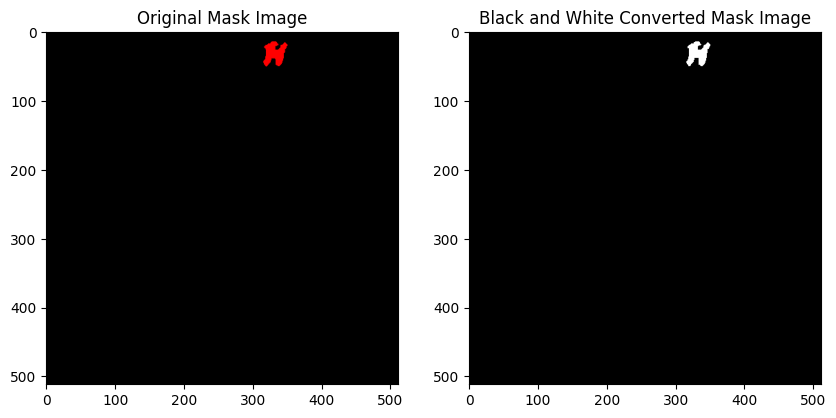

In [5]:
import matplotlib.pyplot as plt
import random

# 랜덤하게 마스크 이미지 하나 선택
random_idx = random.randint(0, len(dataset.mask_paths)-1)
mask_path = dataset.mask_paths[random_idx]

# OpenCV를 이용해 마스크 이미지를 흑백으로 변환하기 전 이미지
original_mask_img = cv2.imread(mask_path)

# 흑백으로 변환
mask = cv2.cvtColor(original_mask_img, cv2.COLOR_BGR2RGB)
mask_red = np.isin(mask[:,:,0], [253, 254, 255])
mask_green = mask[:,:,1] == 0
mask_blue = mask[:,:,2] == 0
mask = np.all(np.stack([mask_red, mask_green, mask_blue], axis=2), axis=2)
mask = np.where(mask, 255, 0).astype(np.uint8)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# 원본 이미지 출력
ax[0].imshow(cv2.cvtColor(original_mask_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Mask Image')

# 흑백 변환 후 이미지 출력
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Black and White Converted Mask Image')

plt.show


모델 학습 및 평가

In [6]:
from sklearn.metrics import f1_score

# Dice coefficient을 계산하는 함수 정의
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# 모델 초기화
model = UNet(in_channels=3, out_channels=1)

# 손실 함수 및 옵티마이저 정의
criterion = nn.BCELoss()  # Change to BCEWithLogitsLoss for stability
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실과 dice_coefs를 저장할 리스트 초기화
train_losses = []
val_losses = []
train_dice_coefs = []
val_dice_coefs = []

best_val_dice_coef = 0  # 최고 성능을 저장할 변수 초기화

# 학습 및 검증
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_dice_coef = 0

    for inputs, masks in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", dynamic_ncols=True):
        inputs, masks = inputs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice_coef += dice_coef(masks.cpu().numpy(), outputs.detach().cpu().numpy())

    average_loss = total_loss / len(train_dataloader)
    average_dice_coef = total_dice_coef / len(train_dataloader)
    train_losses.append(average_loss)
    train_dice_coefs.append(average_dice_coef)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss:.4f}, Training Dice Coef: {average_dice_coef:.4f}")

    model.eval()
    total_val_loss = 0
    total_val_f1 = 0
    total_val_dice_coef = 0

    with torch.no_grad():
        for inputs, masks in val_dataloader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)

            val_loss = criterion(outputs, masks)
            total_val_loss += val_loss.item()
            total_val_dice_coef += dice_coef(masks.cpu().numpy(), outputs.detach().cpu().numpy())

    average_val_loss = total_val_loss / len(val_dataloader)
    average_val_dice_coef = total_val_dice_coef / len(val_dataloader)
    val_losses.append(average_val_loss)
    val_dice_coefs.append(average_val_dice_coef)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}, Validation Dice Coef: {average_val_dice_coef:.4f}")

    # 가장 성능이 좋았던 모델 저장
    if average_val_dice_coef > best_val_dice_coef:
        best_val_dice_coef = average_val_dice_coef
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/deep_learning/drone_segmentation_model.pth')

print("Best model saved with Dice Coefficient: ", best_val_dice_coef)

Epoch 1/40: 100%|██████████| 80/80 [05:19<00:00,  3.99s/it]


Epoch 1/40, Training Loss: 0.2532, Training Dice Coef: 0.0025
Epoch 1/40, Validation Loss: 0.0877, Validation Dice Coef: 0.0028


Epoch 2/40: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Epoch 2/40, Training Loss: 0.0677, Training Dice Coef: 0.0043
Epoch 2/40, Validation Loss: 0.0309, Validation Dice Coef: 0.0102


Epoch 3/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 3/40, Training Loss: 0.0324, Training Dice Coef: 0.0140
Epoch 3/40, Validation Loss: 0.0155, Validation Dice Coef: 0.0321


Epoch 4/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 4/40, Training Loss: 0.0195, Training Dice Coef: 0.0343
Epoch 4/40, Validation Loss: 0.0096, Validation Dice Coef: 0.0577


Epoch 5/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 5/40, Training Loss: 0.0129, Training Dice Coef: 0.0638
Epoch 5/40, Validation Loss: 0.0064, Validation Dice Coef: 0.1202


Epoch 6/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 6/40, Training Loss: 0.0099, Training Dice Coef: 0.0823
Epoch 6/40, Validation Loss: 0.0061, Validation Dice Coef: 0.0946


Epoch 7/40: 100%|██████████| 80/80 [02:01<00:00,  1.52s/it]


Epoch 7/40, Training Loss: 0.0075, Training Dice Coef: 0.1210
Epoch 7/40, Validation Loss: 0.0053, Validation Dice Coef: 0.1114


Epoch 8/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 8/40, Training Loss: 0.0060, Training Dice Coef: 0.1615
Epoch 8/40, Validation Loss: 0.0041, Validation Dice Coef: 0.1945


Epoch 9/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 9/40, Training Loss: 0.0050, Training Dice Coef: 0.1989
Epoch 9/40, Validation Loss: 0.0028, Validation Dice Coef: 0.3072


Epoch 10/40: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Epoch 10/40, Training Loss: 0.0042, Training Dice Coef: 0.2468
Epoch 10/40, Validation Loss: 0.0025, Validation Dice Coef: 0.3597


Epoch 11/40: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Epoch 11/40, Training Loss: 0.0036, Training Dice Coef: 0.2832
Epoch 11/40, Validation Loss: 0.0029, Validation Dice Coef: 0.3416


Epoch 12/40: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Epoch 12/40, Training Loss: 0.0031, Training Dice Coef: 0.3283
Epoch 12/40, Validation Loss: 0.0032, Validation Dice Coef: 0.3332


Epoch 13/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 13/40, Training Loss: 0.0029, Training Dice Coef: 0.3446
Epoch 13/40, Validation Loss: 0.0028, Validation Dice Coef: 0.3912


Epoch 14/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 14/40, Training Loss: 0.0026, Training Dice Coef: 0.3797
Epoch 14/40, Validation Loss: 0.0025, Validation Dice Coef: 0.4385


Epoch 15/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 15/40, Training Loss: 0.0023, Training Dice Coef: 0.4115
Epoch 15/40, Validation Loss: 0.0013, Validation Dice Coef: 0.5826


Epoch 16/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 16/40, Training Loss: 0.0021, Training Dice Coef: 0.4342
Epoch 16/40, Validation Loss: 0.0025, Validation Dice Coef: 0.4785


Epoch 17/40: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Epoch 17/40, Training Loss: 0.0019, Training Dice Coef: 0.4692
Epoch 17/40, Validation Loss: 0.0020, Validation Dice Coef: 0.5507


Epoch 18/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 18/40, Training Loss: 0.0018, Training Dice Coef: 0.4858
Epoch 18/40, Validation Loss: 0.0019, Validation Dice Coef: 0.5406


Epoch 19/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 19/40, Training Loss: 0.0017, Training Dice Coef: 0.5107
Epoch 19/40, Validation Loss: 0.0015, Validation Dice Coef: 0.6476


Epoch 20/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 20/40, Training Loss: 0.0015, Training Dice Coef: 0.5384
Epoch 20/40, Validation Loss: 0.0018, Validation Dice Coef: 0.6173


Epoch 21/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 21/40, Training Loss: 0.0016, Training Dice Coef: 0.5407
Epoch 21/40, Validation Loss: 0.0015, Validation Dice Coef: 0.6370


Epoch 22/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 22/40, Training Loss: 0.0014, Training Dice Coef: 0.5607
Epoch 22/40, Validation Loss: 0.0027, Validation Dice Coef: 0.5195


Epoch 23/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 23/40, Training Loss: 0.0017, Training Dice Coef: 0.5229
Epoch 23/40, Validation Loss: 0.0022, Validation Dice Coef: 0.5432


Epoch 24/40: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Epoch 24/40, Training Loss: 0.0023, Training Dice Coef: 0.4316
Epoch 24/40, Validation Loss: 0.0019, Validation Dice Coef: 0.5378


Epoch 25/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 25/40, Training Loss: 0.0016, Training Dice Coef: 0.5189
Epoch 25/40, Validation Loss: 0.0021, Validation Dice Coef: 0.5571


Epoch 26/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 26/40, Training Loss: 0.0013, Training Dice Coef: 0.5991
Epoch 26/40, Validation Loss: 0.0017, Validation Dice Coef: 0.6321


Epoch 27/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 27/40, Training Loss: 0.0012, Training Dice Coef: 0.6225
Epoch 27/40, Validation Loss: 0.0015, Validation Dice Coef: 0.6610


Epoch 28/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 28/40, Training Loss: 0.0013, Training Dice Coef: 0.5989
Epoch 28/40, Validation Loss: 0.0012, Validation Dice Coef: 0.6538


Epoch 29/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 29/40, Training Loss: 0.0012, Training Dice Coef: 0.6156
Epoch 29/40, Validation Loss: 0.0015, Validation Dice Coef: 0.6745


Epoch 30/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 30/40, Training Loss: 0.0011, Training Dice Coef: 0.6501
Epoch 30/40, Validation Loss: 0.0013, Validation Dice Coef: 0.6862


Epoch 31/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 31/40, Training Loss: 0.0010, Training Dice Coef: 0.6682
Epoch 31/40, Validation Loss: 0.0014, Validation Dice Coef: 0.6910


Epoch 32/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 32/40, Training Loss: 0.0011, Training Dice Coef: 0.6527
Epoch 32/40, Validation Loss: 0.0009, Validation Dice Coef: 0.7488


Epoch 33/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 33/40, Training Loss: 0.0010, Training Dice Coef: 0.6621
Epoch 33/40, Validation Loss: 0.0025, Validation Dice Coef: 0.5498


Epoch 34/40: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 34/40, Training Loss: 0.0009, Training Dice Coef: 0.6772
Epoch 34/40, Validation Loss: 0.0017, Validation Dice Coef: 0.6478


Epoch 35/40: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Epoch 35/40, Training Loss: 0.0008, Training Dice Coef: 0.7176
Epoch 35/40, Validation Loss: 0.0012, Validation Dice Coef: 0.7250


Epoch 36/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 36/40, Training Loss: 0.0009, Training Dice Coef: 0.7277
Epoch 36/40, Validation Loss: 0.0012, Validation Dice Coef: 0.7175


Epoch 37/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 37/40, Training Loss: 0.0008, Training Dice Coef: 0.7205
Epoch 37/40, Validation Loss: 0.0017, Validation Dice Coef: 0.6729


Epoch 38/40: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Epoch 38/40, Training Loss: 0.0008, Training Dice Coef: 0.7433
Epoch 38/40, Validation Loss: 0.0007, Validation Dice Coef: 0.7836


Epoch 39/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 39/40, Training Loss: 0.0008, Training Dice Coef: 0.7338
Epoch 39/40, Validation Loss: 0.0020, Validation Dice Coef: 0.6535


Epoch 40/40: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 40/40, Training Loss: 0.0008, Training Dice Coef: 0.7419
Epoch 40/40, Validation Loss: 0.0053, Validation Dice Coef: 0.4044
Best model saved with Dice Coefficient:  0.7835612422119415


loss, Dice coefficient그래프 시각화

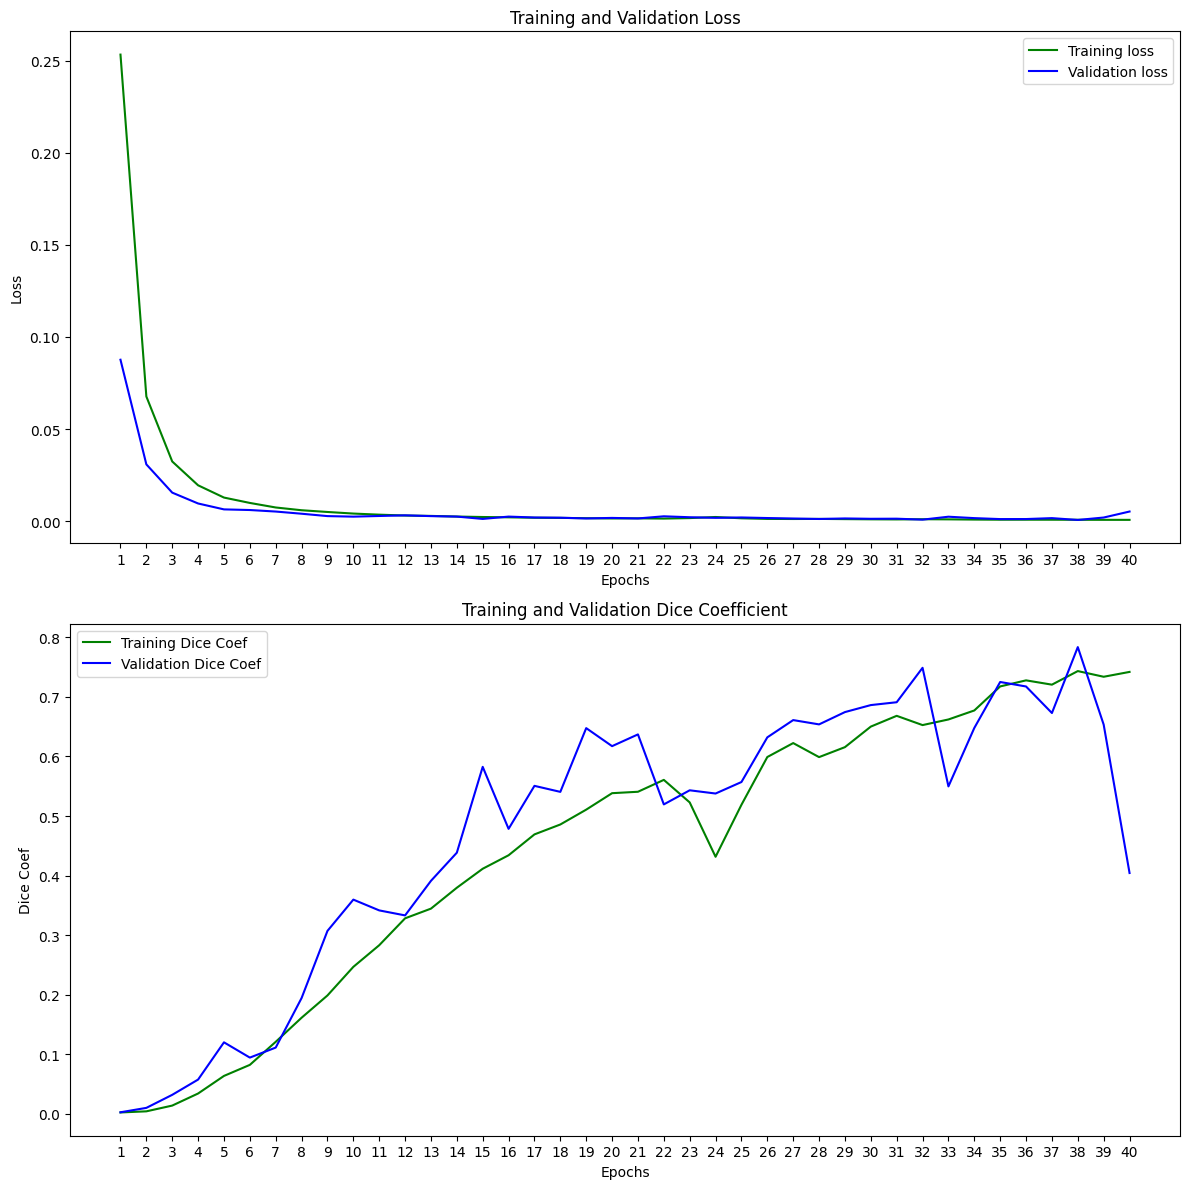

In [7]:
import matplotlib.pyplot as plt

# 에포크 수를 리스트로 변환
epochs = range(1, len(train_losses) + 1)

# 그래프 그리기 - Loss
plt.figure(figsize=(12, 12))  # 가로 길이를 늘림

plt.subplot(2, 1, 1)  # subplot 변경 (2개의 행, 1개의 열)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # x축 눈금 조정
plt.legend()

# 그래프 그리기 - Dice Coefficient
plt.subplot(2, 1, 2)  # subplot 변경 (2개의 행, 1개의 열)
plt.plot(epochs, train_dice_coefs, 'g', label='Training Dice Coef')
plt.plot(epochs, val_dice_coefs, 'b', label='Validation Dice Coef')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.xticks(epochs)  # x축 눈금 조정
plt.legend()

plt.tight_layout()
plt.show()


학습데이터 예측결과 시각화

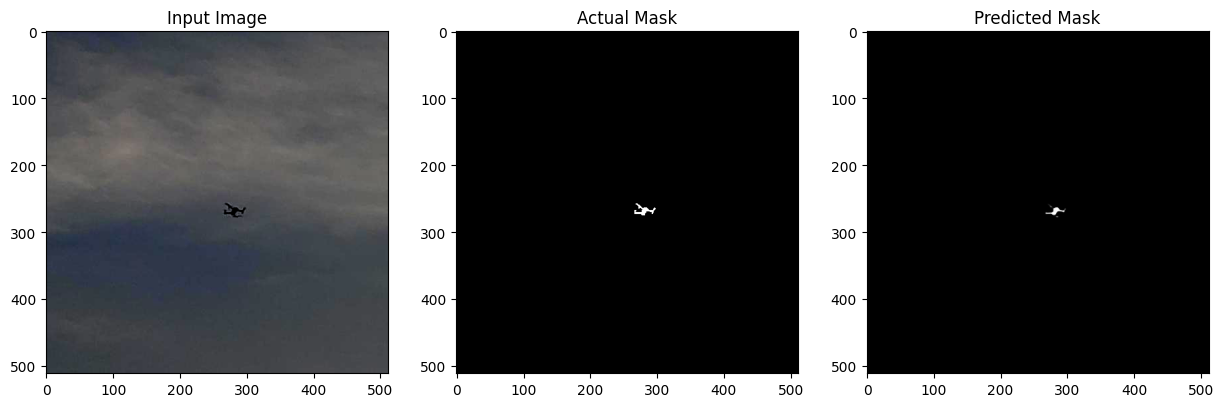

In [9]:
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
model.eval()

# 데이터 로더에서 첫 번째 배치를 가져옴
inputs, masks = next(iter(train_dataloader))
inputs = inputs.to(device)

# 모델에 입력을 전달하여 예측 마스크를 생성
with torch.no_grad():
    outputs = model(inputs)


# 첫 번째 이미지와 마스크, 예측 마스크를 시각화
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 입력 이미지
ax[0].imshow(inputs[0].cpu().permute(1, 2, 0))
ax[0].title.set_text('Input Image')

# 실제 마스크
ax[1].imshow(masks[0].cpu().squeeze(), cmap='gray')
ax[1].title.set_text('Actual Mask')

# 예측 마스크
ax[2].imshow(outputs[0].cpu().squeeze(), cmap='gray')
ax[2].title.set_text('Predicted Mask')

plt.show()


검증데이터 예측결과 시각화

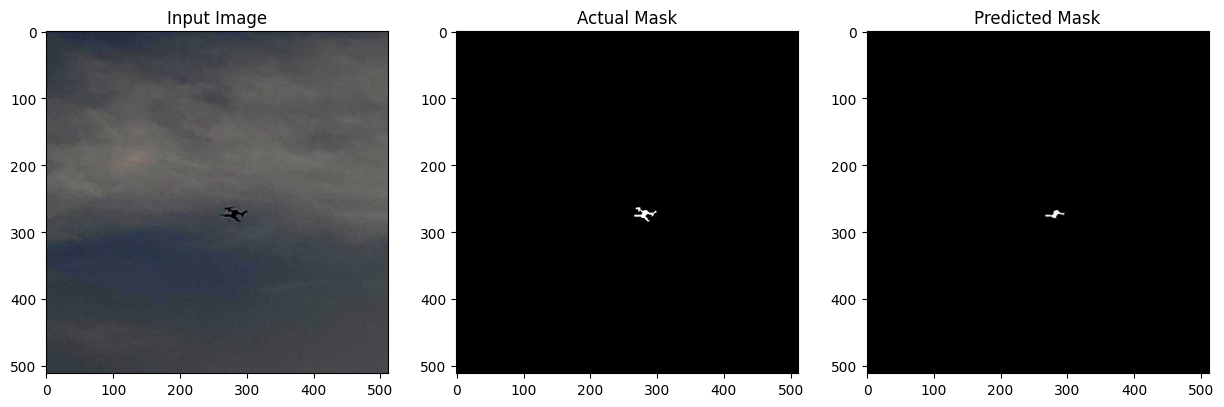

In [10]:
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
model.eval()

# 데이터 로더에서 첫 번째 배치를 가져옴
inputs, masks = next(iter(val_dataloader))
inputs = inputs.to(device)

# 모델에 입력을 전달하여 예측 마스크를 생성
with torch.no_grad():
    outputs = model(inputs)


# 첫 번째 이미지와 마스크, 예측 마스크를 시각화
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 입력 이미지
ax[0].imshow(inputs[0].cpu().permute(1, 2, 0))
ax[0].title.set_text('Input Image')

# 실제 마스크
ax[1].imshow(masks[0].cpu().squeeze(), cmap='gray')
ax[1].title.set_text('Actual Mask')

# 예측 마스크
ax[2].imshow(outputs[0].cpu().squeeze(), cmap='gray')
ax[2].title.set_text('Predicted Mask')

plt.show()


테스트 데이터 예측결과 시각화

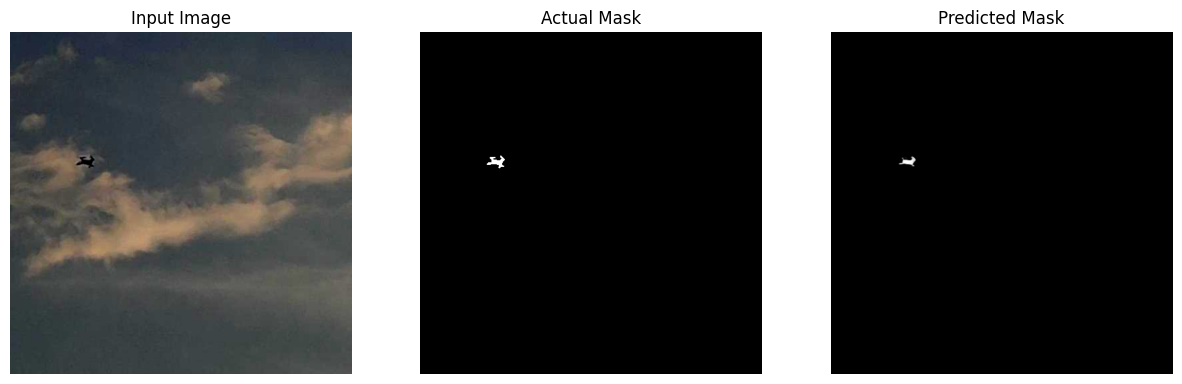

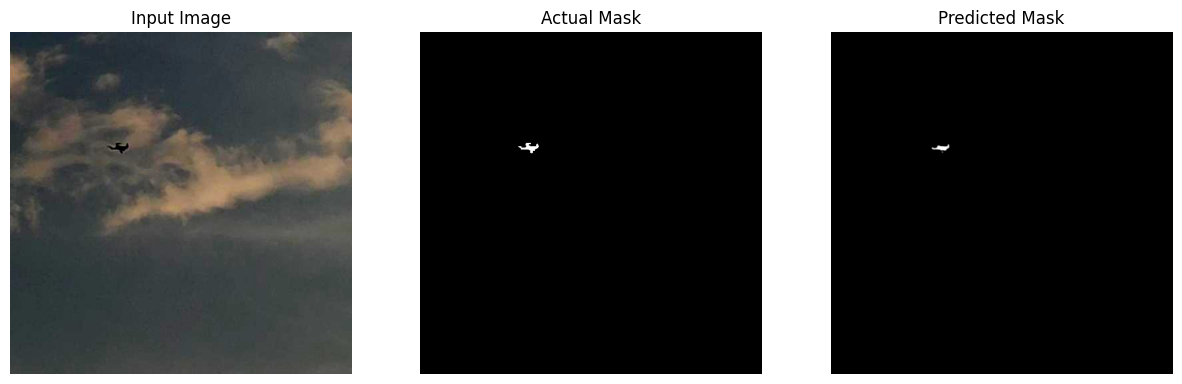

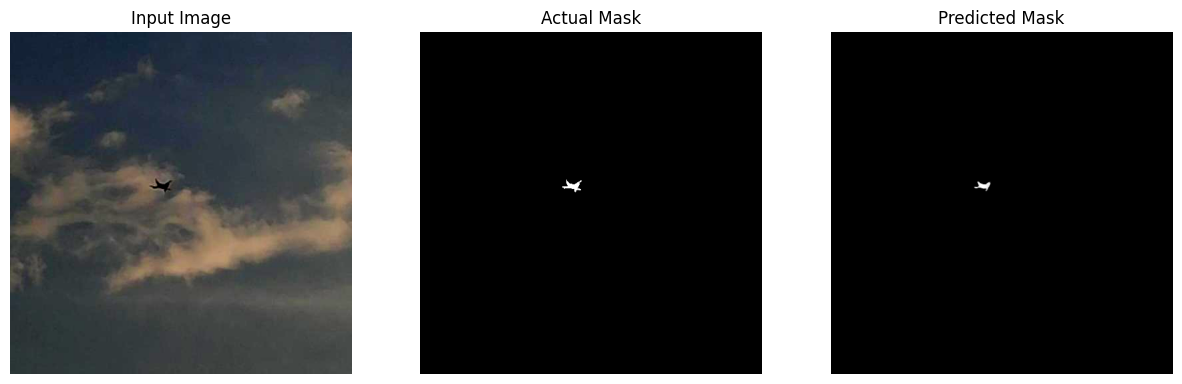

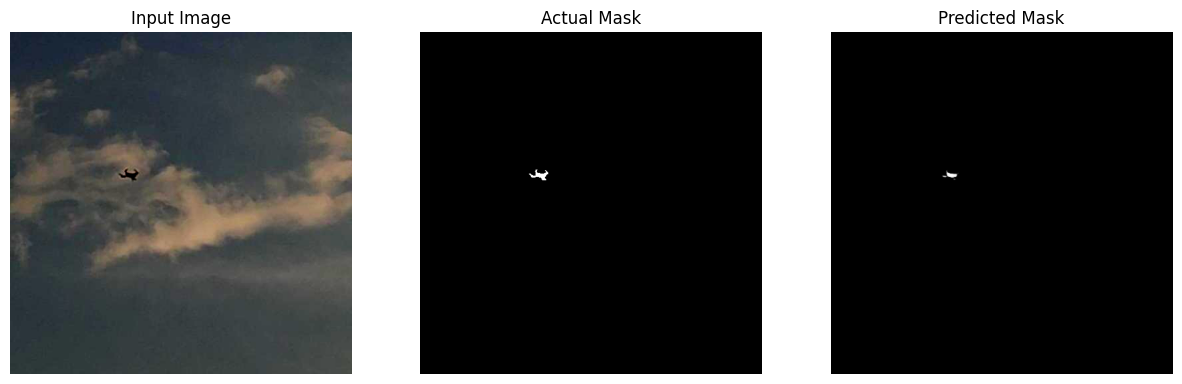

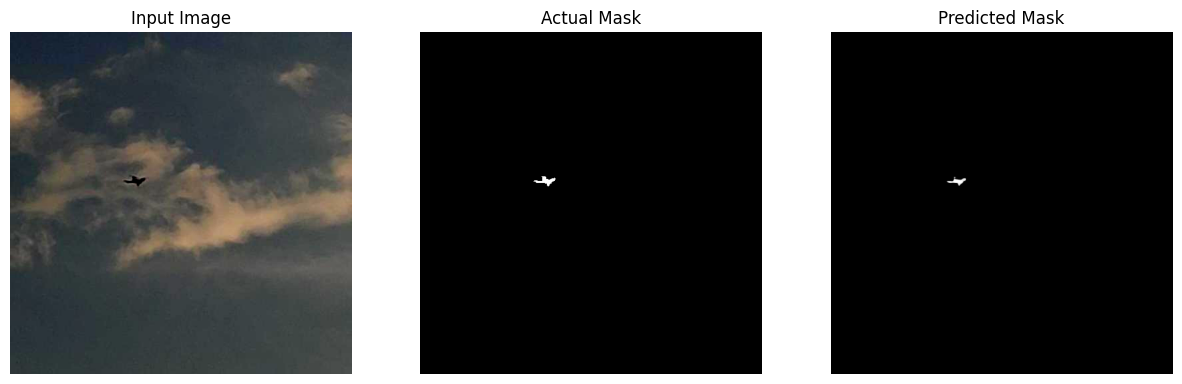

In [11]:
# 테스트 데이터셋 및 데이터 로더 설정
test_image_dir = '/content/drive/MyDrive/Colab Notebooks/deep_learning/crop/test_image'
test_mask_dir = '/content/drive/MyDrive/Colab Notebooks/deep_learning/crop/test_mask'
test_dataset = DroneDataset(test_image_dir, test_mask_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)

# 저장된 모델 불러오기
model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/deep_learning/drone_segmentation_model.pth'))
model.to(device)
model.eval()

# 테스트 데이터에 대한 예측 수행
for i, (inputs, masks) in enumerate(test_dataloader):
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(inputs)

    # 테스트 이미지 출력
    input_image = inputs[0].cpu().numpy()
    input_image = np.moveaxis(input_image, 0, -1)  # Move channel dimension to the end

    # 실제 마스크 이미지 출력
    mask = masks[0].cpu().numpy()
    mask = np.squeeze(mask)  # Remove batch dimension

    # 예측 이미지 출력
    output = outputs[0].cpu().numpy()
    output = np.squeeze(output)  # Remove batch dimension
    #output = output > 0.5  # Apply threshold

    # Create a figure with three subplots
    fig, ax = plt.subplots(1, 3, figsize=(15,5))

    ax[0].imshow(input_image)
    ax[0].set_title("Input Image")

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Actual Mask")

    ax[2].imshow(output, cmap='gray')
    ax[2].set_title("Predicted Mask")

    # Remove axis for all subplots
    for a in ax:
        a.axis('off')

    plt.show()


영상 데이터 예측

In [18]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image


# 모델 불러오기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/deep_learning/drone_segmentation_model.pth'))
model.eval()

import os

# 비디오 불러오기
video_path = '/content/drive/MyDrive/Colab Notebooks/deep_learning/drone_video1.mp4'
cap = cv2.VideoCapture(video_path)

# 입력된 비디오 이름에 "segmentation_" 추가
base_name = os.path.basename(video_path)  # 파일 이름만 추출
name, ext = os.path.splitext(base_name)  # 파일 이름과 확장자 나누기
new_name = "segmentation_" + name + ext  # 새로운 이름 생성

# 새로운 경로 생성
new_path = os.path.join(os.path.dirname(video_path), new_name)

# 비디오 쓰기 설정
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(new_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (512, 512))

# 전처리 파이프라인 설정
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # 사이즈 조정
    transforms.ToTensor(),  # 텐서 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
])


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 프레임 전처리
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR을 사용하므로 RGB로 변경
    frame = Image.fromarray(frame)  # PIL 이미지로 변환
    frame = preprocess(frame)
    frame = frame.unsqueeze(0)
    frame = frame.to(device)

    # 예측 수행
    with torch.no_grad():
        output = model(frame)

    # 예측 결과를 시각화하거나 저장
    output = output.squeeze().cpu().numpy()
    output = (output * 255).astype(np.uint8)
    output_rgb = cv2.cvtColor(output, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    output_resized = cv2.resize(output_rgb, (512, 512))
    out.write(output_resized)

cap.release()
out.release()
